# **Task2.1 Build and analyse the performance of multiple ML models (10%)**

### **Data Extraction**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Load the Adult Census Income dataset
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

# Define the URL for the data
train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

# Load the data
train_data = pd.read_csv(train_url, names=column_names, sep=',\s*', engine='python', na_values='?')
test_data = pd.read_csv(test_url, names=column_names, sep=',\s*', engine='python', na_values='?', skiprows=1)

# Clean income labels in test data (remove dots)
test_data['income'] = test_data['income'].str.replace('.', '')

# Combine both datasets for EDA and preprocessing
combined_data = pd.concat([train_data, test_data])

In [3]:
# Exploratory Data Analysis
print("Dataset shape:", combined_data.shape)
print("\nMissing values per column:")
print(combined_data.isnull().sum())

# Check target distribution
print("\nTarget distribution:")
print(combined_data['income'].value_counts(normalize=True) * 100)

Dataset shape: (48842, 15)

Missing values per column:
age                  0
workclass         2799
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income               0
dtype: int64

Target distribution:
income
<=50K    76.071823
>50K     23.928177
Name: proportion, dtype: float64


### **Exploratory Data Analysis**
---
#### **1. Missing Values Analysis**
- **Workclass** (2799 missing), **Occupation** (2809 missing), and **Native Country** (857 missing) have missing values.
- **Missing values percentage:**
  - **Workclass:** ~5.73%
  - **Occupation:** ~5.75%
  - **Native Country:** ~1.75%
- These missing values should either be **imputed** (e.g., with the mode or "Unknown") or **dropped** if they are not critical.

#### **2. Target Variable Distribution**
- **76.07% of people earn ≤50K**, while **23.93% earn >50K**.
- The dataset is imbalanced, meaning models might favor predicting lower-income unless balanced by weighting techniques, resampling, or adjusting the threshold.

#### **3. Workclass Distribution**
- **73.64% of individuals work in the Private sector**.
- **Self-employed (not incorporated) and Government jobs account for ~20%**.
- **Takeaway:** Private-sector work dominates income prediction, but government jobs and self-employment should not be overlooked.

#### **4. Education Distribution**
- **32.31% of people are high school graduates**.
- **22.27% have some college education**, and **16.43% hold a Bachelor's degree**.
- **Higher education levels (Masters & Associate degrees) make up ~10%**.
- **Takeaway:** Education is a strong predictor of income, but most people have a high school or lower education.

#### **5. Marital Status**
- **46% are married-civ-spouse**.
- **33% have never been married**.
- **Takeaway:** **Married people have historically higher income levels**, which aligns with feature importance results.

#### **6. Occupation Distribution**
- **Top occupations:** Professional-Specialty (13.4%), Craft-Repair (13.3%), Executive-Managerial (13.2%).
- **Takeaway:** Executive and Professional jobs tend to correlate with higher salaries.

#### **7. Relationship Status**
- **40.3% are "Husbands"**, followed by **25.7% "Not-in-Family" individuals**.
- **Takeaway:** Being a "Husband" is a strong indicator of earning >50K, as seen in feature importance.

#### **8. Race & Gender**
- **85.5% are White, 9.6% Black, and 3.1% Asian-Pac-Islander**.
- **66.8% Male, 33.1% Female**.
- **Takeaway:** Gender and racial disparities in income may be present, requiring fairness analysis.

#### **9. Native Country**
- **91.3% of the dataset is from the United States**, followed by **Mexico (1.98%)**.
- **Takeaway:** Most income predictions will be biased toward the U.S. economy.

---

### **Next Steps / Suggestions**
- **Handle Missing Values:** Impute missing workclass, occupation, and native country.  
- **Stratified Splitting:** Perform stratification in train/test split to account for class imbalance.


### **Data Preprocessing**

In [4]:
# Handle missing values
# For categorical features with missing values, impute with the most frequent value
combined_data['workclass'] = combined_data['workclass'].fillna(combined_data['workclass'].mode()[0])
combined_data['occupation'] = combined_data['occupation'].fillna(combined_data['occupation'].mode()[0])
combined_data['native_country'] = combined_data['native_country'].fillna(combined_data['native_country'].mode()[0])

# Alternative approach: create a new category for missing values
# combined_data['workclass'] = combined_data['workclass'].fillna('Unknown')
# combined_data['occupation'] = combined_data['occupation'].fillna('Unknown')
# combined_data['native_country'] = combined_data['native_country'].fillna('Unknown')

# Convert target to binary
combined_data['income'] = combined_data['income'].map({'>50K': 1, '<=50K': 0, '>50K.': 1, '<=50K.': 0})

### **Data Splitting**

In [5]:
# Split features and target
X = combined_data.drop('income', axis=1)
y = combined_data['income']

# Define numerical and categorical features
numerical_features = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
categorical_features = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

# # Resplit the data back into train and test for modeling
# # Get the original train/test split indices
# train_idx = range(len(train_data))
# test_idx = range(len(train_data), len(combined_data))

# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Stratified train/test split (replace existing split code)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,  # Adjust as needed to match desired split ratio
    random_state=42,  # For reproducibility
    stratify=y  # This ensures the same class distribution in train and test sets
)

# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

# Define hyperparameter grids for each model
param_grids = {
    'Random Forest': {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [10, 20, 30],
        'model__min_samples_split': [2, 5],
        'model__min_samples_leaf': [1, 2]
    },
    'Logistic Regression': {
        'model__C': [0.01, 0.1, 1, 10, 100],
        'model__solver': ['liblinear', 'saga'],
        'model__penalty': ['l1', 'l2']
    }
}

# Check categorical features distributions
for feature in categorical_features:
    print(f"\nDistribution of {feature}:")
    print(X[feature].value_counts(normalize=True).head(5) * 100)

# Create preprocessors for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Storage for results
results = {}
best_models = {}
feature_importances = {}


Distribution of workclass:
workclass
Private             75.150485
Self-emp-not-inc     7.907129
Local-gov            6.420703
State-gov            4.055935
Self-emp-inc         3.470374
Name: proportion, dtype: float64

Distribution of education:
education
HS-grad         32.316449
Some-college    22.271815
Bachelors       16.430531
Masters          5.439990
Assoc-voc        4.219729
Name: proportion, dtype: float64

Distribution of marital_status:
marital_status
Married-civ-spouse    45.819172
Never-married         32.998239
Divorced              13.580525
Separated              3.132550
Widowed                3.107981
Name: proportion, dtype: float64

Distribution of occupation:
occupation
Prof-specialty     18.387863
Craft-repair       12.513820
Exec-managerial    12.460587
Adm-clerical       11.488064
Sales              11.268990
Name: proportion, dtype: float64

Distribution of relationship:
relationship
Husband          40.366897
Not-in-family    25.762663
Own-child        15.5

In [6]:
# Check if missing values were handled
print("Dataset shape:", combined_data.shape)
print("\nMissing values per column:")
print(combined_data.isnull().sum())

# Check target distribution is in the right format
print("\nTarget distribution:")
print(combined_data['income'].value_counts(normalize=True) * 100)

Dataset shape: (48842, 15)

Missing values per column:
age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

Target distribution:
income
0    76.071823
1    23.928177
Name: proportion, dtype: float64


### **Model Training**


Training Random Forest...
Best parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Accuracy: 0.8673
ROC AUC: 0.9189

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7431
           1       0.78      0.62      0.69      2338

    accuracy                           0.87      9769
   macro avg       0.83      0.78      0.80      9769
weighted avg       0.86      0.87      0.86      9769



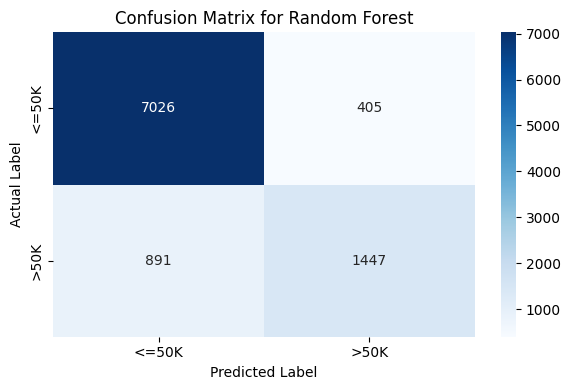

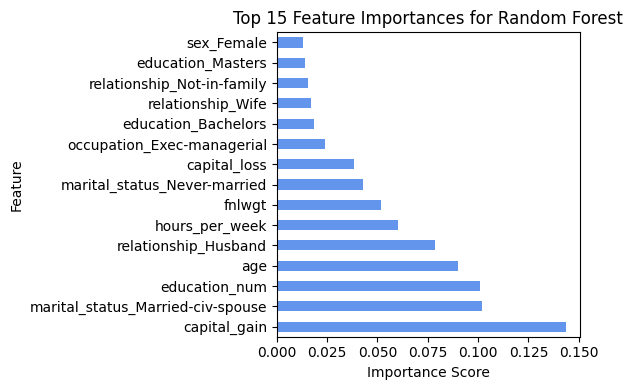


Training Logistic Regression...
Best parameters: {'model__C': 1, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Accuracy: 0.8508
ROC AUC: 0.9042

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7431
           1       0.73      0.59      0.66      2338

    accuracy                           0.85      9769
   macro avg       0.81      0.76      0.78      9769
weighted avg       0.84      0.85      0.85      9769



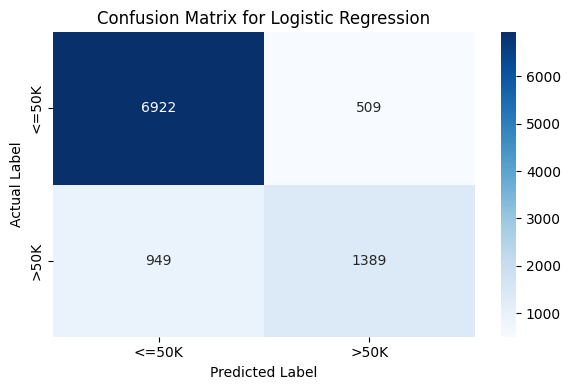

In [7]:
# Create dictionary to store ROC curve data for later plotting
roc_data = {}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Grid search with cross validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    # Fit the model
    grid_search.fit(X_train, y_train)
    best_models[name] = grid_search.best_estimator_

    # Make predictions
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'ROC AUC': auc,
        'Best Parameters': grid_search.best_params_
    }

    # Print results
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix in a separate figure
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['<=50K', '>50K'],
                yticklabels=['<=50K', '>50K'])
    plt.xlabel('Predicted Label', fontsize=10)
    plt.ylabel('Actual Label', fontsize=10)
    plt.title(f'Confusion Matrix for {name}', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Store ROC curve data for later plotting
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc}

    # Get feature importances for tree-based models
    if name in ['Decision Tree', 'Random Forest']:
        model_step = best_models[name].named_steps['model']
        preprocessor_step = best_models[name].named_steps['preprocessor']

        # Get feature names from the preprocessor
        ohe = preprocessor_step.named_transformers_['cat'].named_steps['onehot']
        feature_names = numerical_features + list(ohe.get_feature_names_out(categorical_features))

        # Store feature importances
        feature_importances[name] = pd.Series(
            model_step.feature_importances_,
            index=feature_names
        ).sort_values(ascending=False)

        # Plot feature importances in a separate figure
        plt.figure(figsize=(6, 4))
        importances = feature_importances[name]
        importances.head(15).plot(kind='barh', color='cornflowerblue')
        plt.title(f'Top 15 Feature Importances for {name}', fontsize=12)
        plt.xlabel('Importance Score', fontsize=10)
        plt.ylabel('Feature', fontsize=10)
        plt.tight_layout()
        plt.savefig(f'feature_importance_{name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()

### **Random Forest vs Logistic Regression**

---

#### **1. Feature Importance (Random Forest)**
The most important features influencing income prediction are:
  - **Capital gain**
  - Marital status (Married-civ-spouse)
  - Education level (Num of years)
  - Age
  - Relationship status
  - Hours per week

These features align well with real-world expectations where higher education, stable marital status, and financial indicators influence income levels. A higher capital gain typically correlates with higher income levels, as wealthy individuals often have investments. Relationship roles (Husband/Wife) correlate with higher earnings, likely reflecting traditional labor market trends.

---

#### **2. Confusion Matrices**
**Random Forest Model**
  - True Negatives (≤50K correctly classified): **7,026**
  - False Positives (≤50K misclassified as >50K): **405**
  - False Negatives (>50K misclassified as ≤50K): **891**
  - True Positives (>50K correctly classified): **1,447**

**Logistic Regression Model**
  - True Negatives: **6,922** (slightly worse than RF)
  - False Positives: **509** (higher than RF)
  - False Negatives: **949** (similar to RF)
  - True Positives: **1,389** (similar to RF)


#### **3. Model Performance Analysis**

---

 **Performance Summary**

| Model                 | Accuracy | ROC AUC | Precision (≤50K) | Recall (≤50K) | Precision (>50K) | Recall (>50K) |
|-----------------------|----------|----------|------------------|---------------|------------------|---------------|
| **Random Forest**     | **0.8673** | **0.9189** | **0.89** | **0.95** | **0.78** | **0.62** |
| **Logistic Regression** | 0.8508 | 0.9042 | **0.88** | 0.93 | **0.73** | **0.59** |

---

**Key Observations**

1. **Random Forest Outperforms Logistic Regression**
 - **Higher Accuracy (86.73% vs 85.08%)** → Random Forest makes fewer mistakes overall.
 - **Higher ROC AUC (91.89% vs 90.42%)** → Better ability to distinguish between income groups.

2. **Recall for High Earners (>50K) is Higher in Random Forest**

  **RF Recall = 62%**, while **LogReg Recall = 59%**, meaning Random Forest is better at detecting high-income individuals.

3. **Logistic Regression has a Slightly Lower False Positive Rate**

  Precision for **>50K is higher in RF (78%) vs LogReg (73%)**, meaning Random Forest makes fewer mistakes when predicting someone earns >50K.

4. **Trade-offs**

  - **Random Forest is better at identifying high earners** but still struggles with **Recall (62%)**, meaning it misses some high-income cases.
  - **Logistic Regression is more conservative**, meaning it’s **less likely to classify someone as >50K unless very certain**, leading to fewer False Positives.


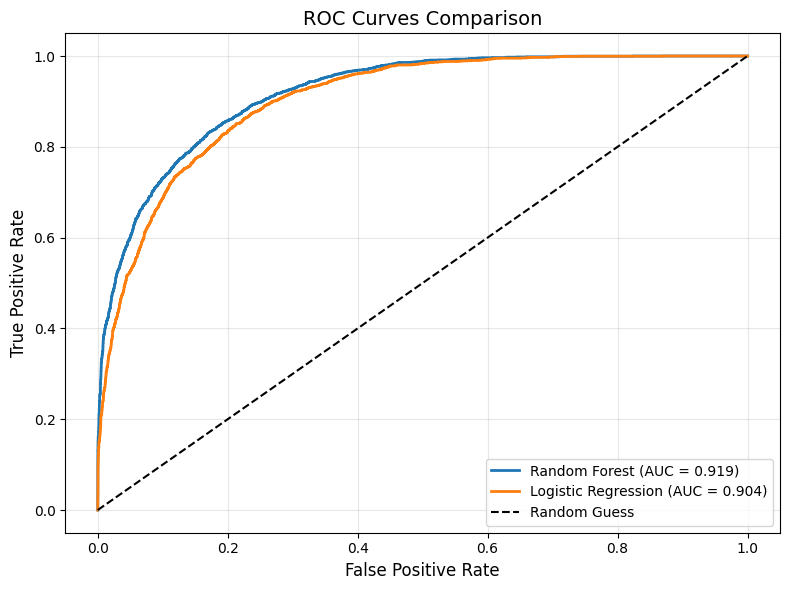

In [8]:
# Create a dedicated figure for ROC curves after all models are trained
plt.figure(figsize=(8, 6))
plt.grid(True, alpha=0.3)
plt.title('ROC Curves Comparison', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)

# Plot all ROC curves
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], linewidth=2, label=f'{name} (AUC = {data["auc"]:.3f})')

# Add random guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#### **4. ROC AUC Curve**

##### **Understanding the ROC AUC**
- **ROC AUC (Receiver Operating Characteristic - Area Under the Curve)** is a key metric used to evaluate the performance of a **classification model**, especially for imbalanced datasets.
- The **ROC curve** is a graph that plots the **True Positive Rate (Sensitivity/Recall)** against the **False Positive Rate** at different classification thresholds.
- It helps visualize how well a model differentiates between two classes.
- **AUC (Area Under the Curve)** quantifies the overall ability of the model to discriminate between positive (**>50K**) and negative (**≤50K**) classes.

##### **Interpreting the ROC AUC**
- **Higher AUC = Better Classification Performance**  
  - **AUC = 1.0:** Perfect classification (ideal model)
  - **AUC = 0.5:** Random guessing (like flipping a coin)
  - **AUC < 0.5:** Worse than random guessing (rare, indicates model is confused)
- Both models perform well, but **Random Forest (AUC = 0.919)** has a slight edge over **Logistic Regression (AUC = 0.904)** in discriminating between income classes.
- The curves show that both models significantly outperform random guessing (diagonal line).


##### **ROC AUC Importance**
- It doesn't depend on a specific threshold, unlike accuracy or precision.
- It is useful for imbalanced datasets, since accuracy alone can be misleading (e.g., if 90% of people earn ≤50K, a model predicting everyone earns ≤50K would have 90% accuracy but would be useless).
- It helps compare models objectively as higher AUC means better generalization ability.

In [9]:
# Display results table
results_df = pd.DataFrame({
    model_name: {
        'Accuracy': results[model_name]['Accuracy'],
        'ROC AUC': results[model_name]['ROC AUC']
    } for model_name in results.keys()
}).T

print("\nModel Performance Comparison:")
print(results_df.sort_values('ROC AUC', ascending=False))


Model Performance Comparison:
                     Accuracy   ROC AUC
Random Forest        0.867335  0.918908
Logistic Regression  0.850752  0.904188


#### **Key Takeaways**
- Random Forest is the superior model in terms of accuracy (86.7%) and ROC AUC (91.9%).  
- Logistic Regression is a good baseline model, but it struggles with high-income classification.  
- Feature Importance Analysis shows that financial indicators (capital gain, education, and marital status) are the strongest predictors of income.  
- Both models have relatively low recall for high earners, meaning further tuning or additional feature engineering could help improve performance.

---

### **Next Steps / Possible Improvements**
- **Address class imbalance**: The dataset has more low-income individuals; try oversampling the high-income group.  
- **Feature engineering**: Consider feature interactions, new financial indicators, or removing less significant variables.  
- **Hyperparameter tuning**: Further refine hyperparameters (e.g., increasing max depth for RF or adjusting class weights in logistic regression).  
- **Try other models**: Explore Gradient Boosting (XGBoost, LightGBM) for potentially better performance.  

# **Task2.2 Error analysis (30%)**

In [10]:
# Define protected attributes for intersectional analysis
protected_attributes = ['sex', 'race']
sensitive_intersections = ['sex', 'race']

# Function to calculate fairness metrics for different groups
def calculate_fairness_metrics(model, X, y, attribute):
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    groups = X[attribute].unique()
    metrics = {}

    for group in groups:
        group_idx = X[attribute] == group
        if sum(group_idx) > 0:  # Ensure we have samples
            # True positive rate (Recall for positive class)
            tpr = sum((y_pred[group_idx] == 1) & (y[group_idx] == 1)) / max(1, sum(y[group_idx] == 1))

            # False positive rate
            fpr = sum((y_pred[group_idx] == 1) & (y[group_idx] == 0)) / max(1, sum(y[group_idx] == 0))

            # Precision for positive class
            precision = sum((y_pred[group_idx] == 1) & (y[group_idx] == 1)) / max(1, sum(y_pred[group_idx] == 1))

            # Overall accuracy
            accuracy = sum(y_pred[group_idx] == y[group_idx]) / max(1, sum(group_idx))

            # Disparate impact (ratio of positive predictions)
            positive_rate = sum(y_pred[group_idx] == 1) / max(1, sum(group_idx))

            metrics[group] = {
                'count': sum(group_idx),
                'tpr': tpr,
                'fpr': fpr,
                'precision': precision,
                'accuracy': accuracy,
                'positive_rate': positive_rate
            }

    return metrics

# Calculate equalized odds difference (max TPR difference or max FPR difference)
def calculate_equalized_odds_difference(metrics):
    tpr_values = [metrics[group]['tpr'] for group in metrics]
    fpr_values = [metrics[group]['fpr'] for group in metrics]

    tpr_diff = max(tpr_values) - min(tpr_values)
    fpr_diff = max(fpr_values) - min(fpr_values)

    return max(tpr_diff, fpr_diff)

# Calculate demographic parity difference (max difference in positive prediction rate)
def calculate_demographic_parity_difference(metrics):
    pos_rates = [metrics[group]['positive_rate'] for group in metrics]
    return max(pos_rates) - min(pos_rates)

# Create intersectional groups
def create_intersection_column(X, attributes):
    return X[attributes].apply(lambda x: '_'.join(x.astype(str)), axis=1)


Fairness Analysis for Random Forest:

Sex analysis:
         Count  Accuracy       TPR       FPR  Precision  Positive Rate
Male    6480.0  0.835031  0.634196  0.077179   0.782228       0.246605
Female  3289.0  0.930982  0.536785  0.019507   0.775591       0.077227

Race analysis:
                     Count  Accuracy       TPR       FPR  Precision  \
White               8348.0  0.861284  0.623407  0.057794   0.785842   
Other                 69.0  0.898551  0.454545  0.017241   0.833333   
Black                944.0  0.921610  0.520661  0.019441   0.797468   
Asian-Pac-Islander   304.0  0.838816  0.679487  0.106195   0.688312   
Amer-Indian-Eskimo   104.0  0.923077  0.555556  0.042105   0.555556   

                    Positive Rate  
White                    0.201366  
Other                    0.086957  
Black                    0.083686  
Asian-Pac-Islander       0.253289  
Amer-Indian-Eskimo       0.086538  

Fairness Analysis for Logistic Regression:

Sex analysis:
         Count  

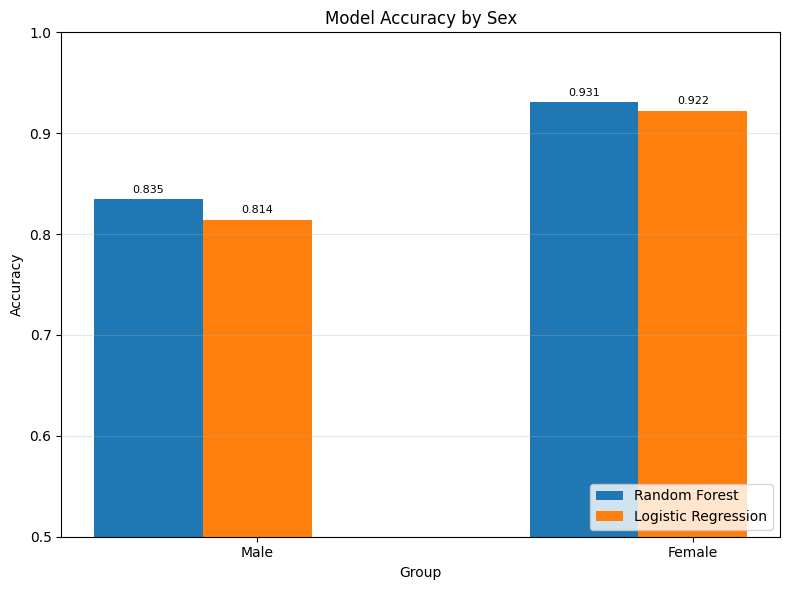

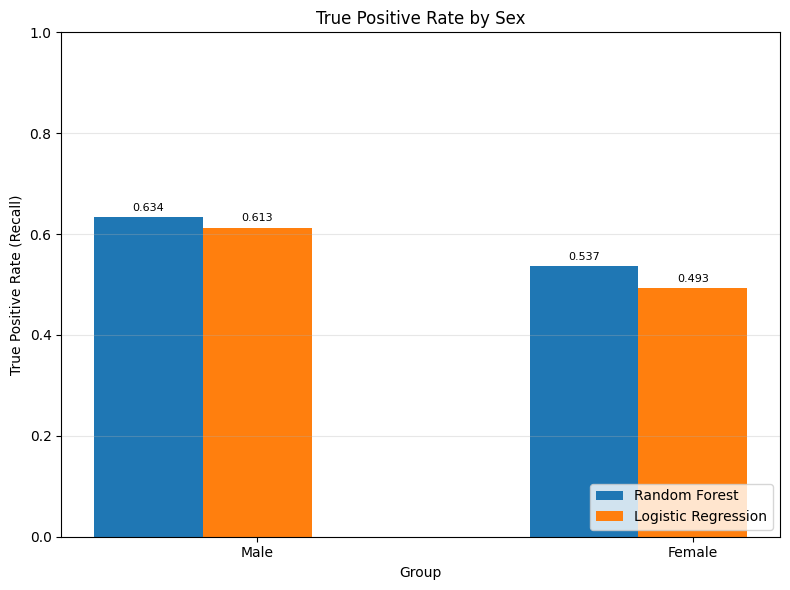

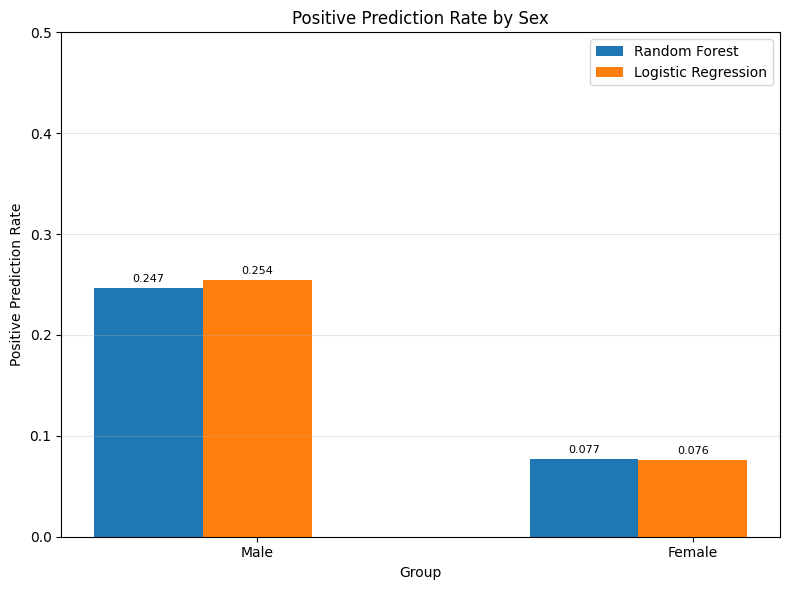

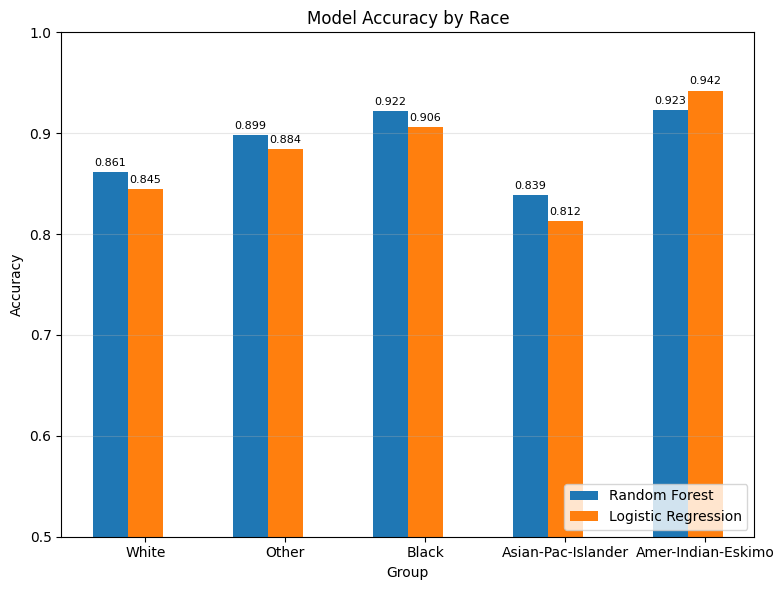

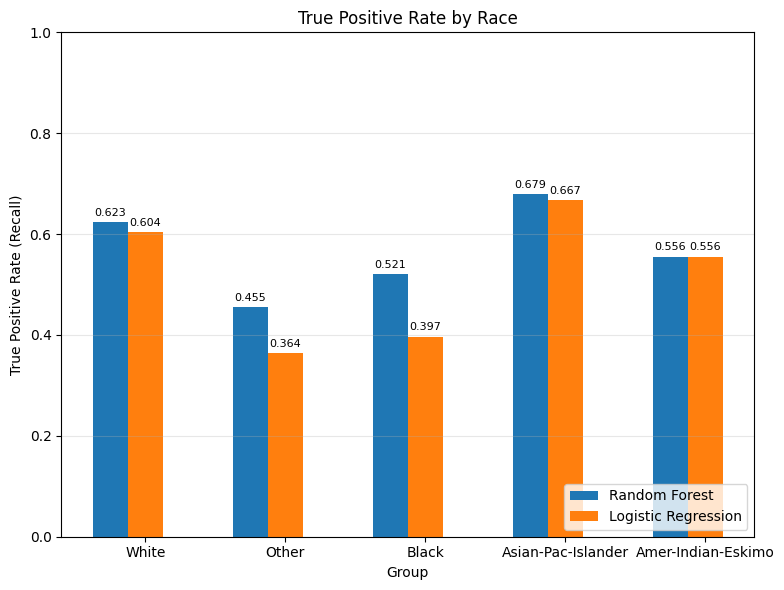

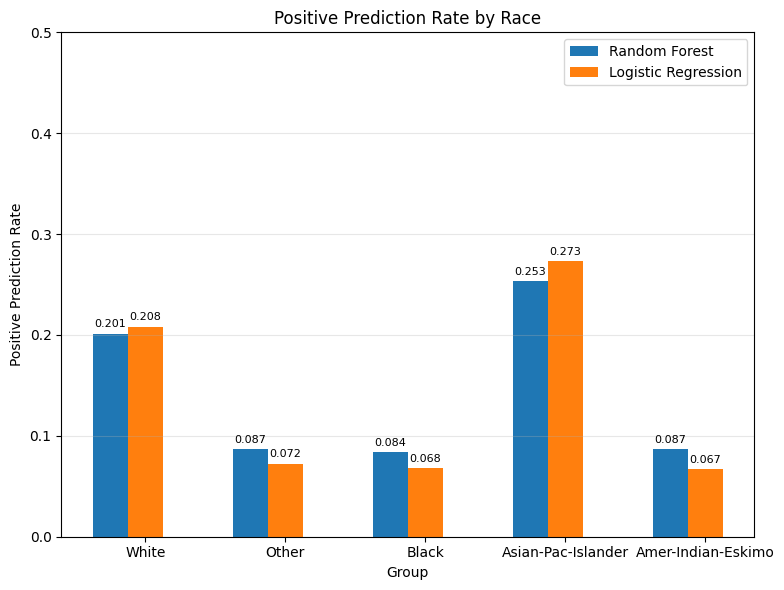

<Figure size 1200x1000 with 0 Axes>

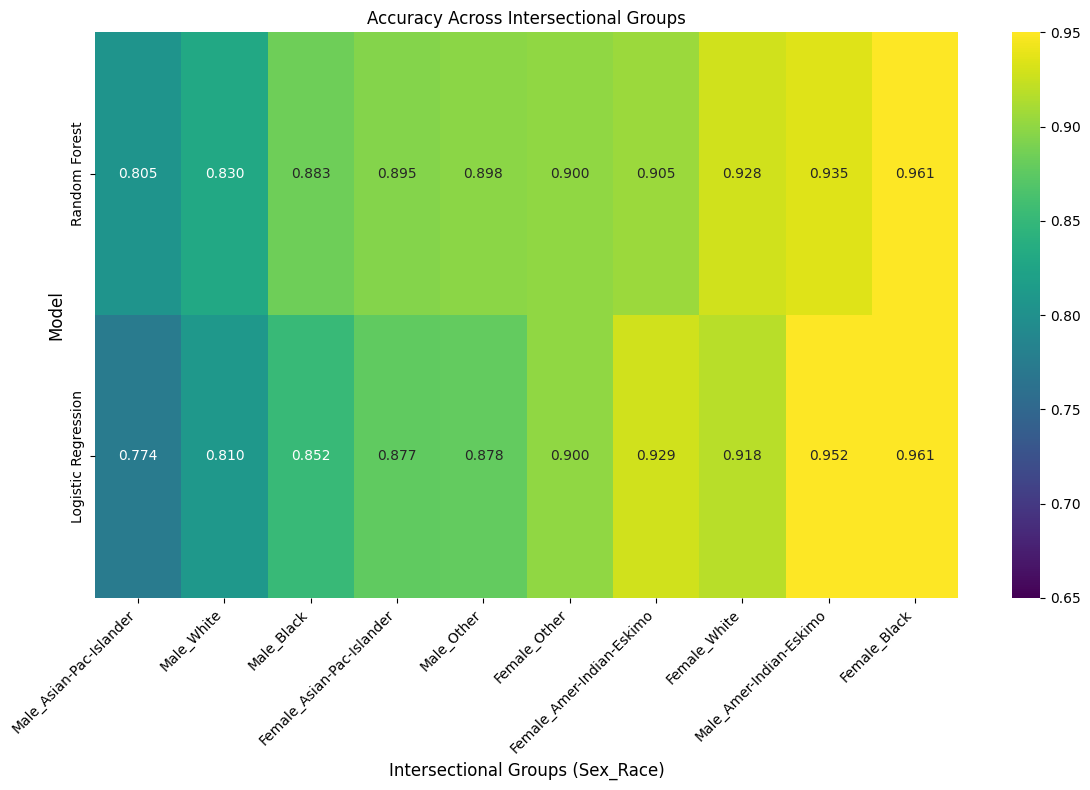

<Figure size 800x600 with 0 Axes>

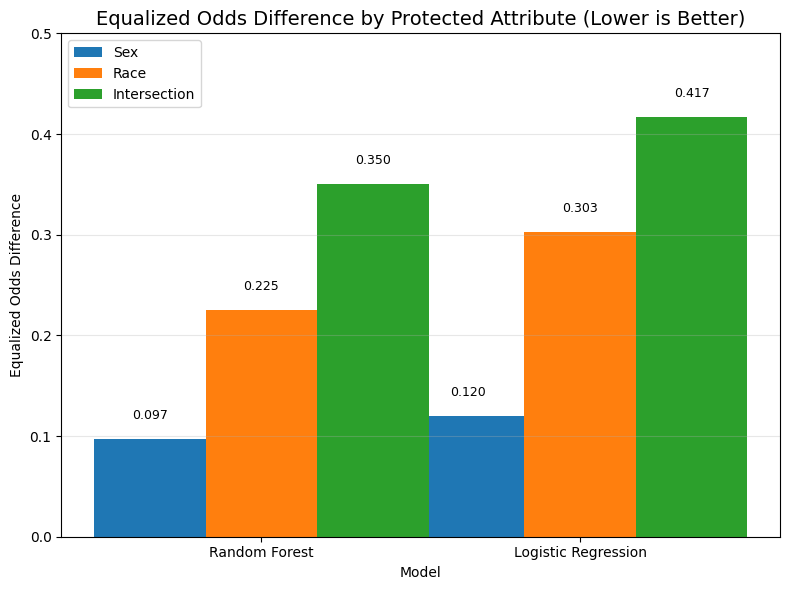

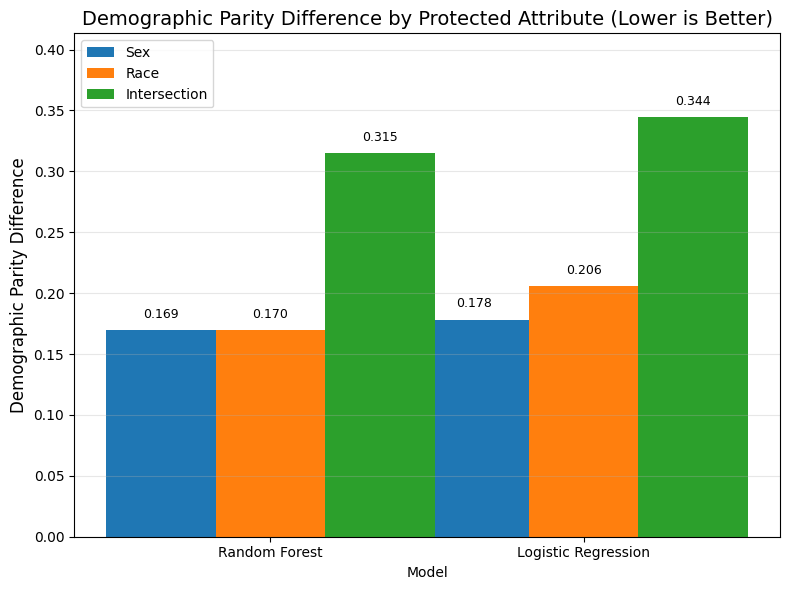

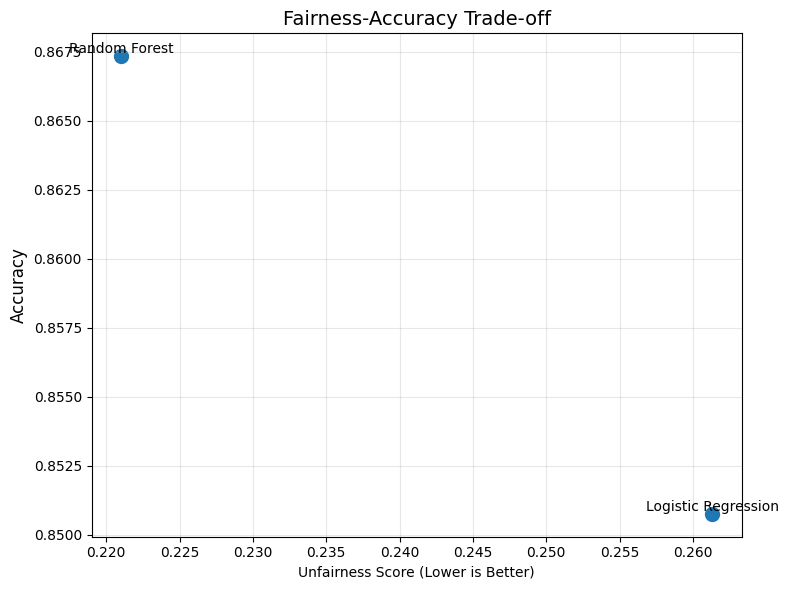


Fairness Score Summary (Lower is Better):
Random Forest: 0.2210
Logistic Regression: 0.2613

Most Fair Model: Random Forest
Least Fair Model: Logistic Regression


In [11]:
# For each model, analyze fairness for different protected attributes
fairness_results = {}
intersectional_results = {}
equalized_odds = {}
demographic_parity = {}

for name, model in best_models.items():
    print(f"\nFairness Analysis for {name}:")
    fairness_results[name] = {}
    equalized_odds[name] = {}
    demographic_parity[name] = {}

    # Analyze each protected attribute
    for attribute in protected_attributes:
        fairness_results[name][attribute] = calculate_fairness_metrics(model, X_test, y_test, attribute)

        # Calculate fairness metrics
        equalized_odds[name][attribute] = calculate_equalized_odds_difference(fairness_results[name][attribute])
        demographic_parity[name][attribute] = calculate_demographic_parity_difference(fairness_results[name][attribute])

        print(f"\n{attribute.capitalize()} analysis:")
        metrics_df = pd.DataFrame({
            group: {
                'Count': fairness_results[name][attribute][group]['count'],
                'Accuracy': fairness_results[name][attribute][group]['accuracy'],
                'TPR': fairness_results[name][attribute][group]['tpr'],
                'FPR': fairness_results[name][attribute][group]['fpr'],
                'Precision': fairness_results[name][attribute][group]['precision'],
                'Positive Rate': fairness_results[name][attribute][group]['positive_rate']
            } for group in fairness_results[name][attribute]
        }).T

        print(metrics_df)

    # Intersectional analysis
    X_test_with_intersection = X_test.copy()
    X_test_with_intersection['intersection'] = create_intersection_column(X_test, sensitive_intersections)

    # Calculate metrics for intersectional groups
    intersectional_results[name] = calculate_fairness_metrics(model, X_test_with_intersection, y_test, 'intersection')

    # Calculate fairness metrics for intersectional groups
    equalized_odds[name]['intersection'] = calculate_equalized_odds_difference(intersectional_results[name])
    demographic_parity[name]['intersection'] = calculate_demographic_parity_difference(intersectional_results[name])

# Visualize fairness metrics across groups
for attribute in protected_attributes:
    # Create accuracy comparison plot
    plt.figure(figsize=(8, 6))

    # Prepare data for grouped bar chart
    groups = list(fairness_results[list(fairness_results.keys())[0]][attribute].keys())
    model_names = list(fairness_results.keys())

    x = np.arange(len(groups))
    width = 0.25
    multiplier = 0

    for model_name in model_names:
        accuracies = [fairness_results[model_name][attribute][group]['accuracy'] for group in groups]
        offset = width * multiplier
        rects = plt.bar(x + offset, accuracies, width, label=model_name)
        # Add value labels on bars
        for rect, acc in zip(rects, accuracies):
            height = rect.get_height()
            plt.annotate(f'{acc:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=0, fontsize=8)
        multiplier += 1

    plt.xlabel('Group', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title(f'Model Accuracy by {attribute.capitalize()}', fontsize=12)
    plt.xticks(x + width, groups)
    plt.ylim(0.5, 1.0)  # Set y-axis range for better visualization
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'accuracy_by_{attribute}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create TPR comparison plot (True Positive Rate = Recall for positive class)
    plt.figure(figsize=(8, 6))
    multiplier = 0

    for model_name in model_names:
        tprs = [fairness_results[model_name][attribute][group]['tpr'] for group in groups]
        offset = width * multiplier
        rects = plt.bar(x + offset, tprs, width, label=model_name)
        for rect, tpr in zip(rects, tprs):
            height = rect.get_height()
            plt.annotate(f'{tpr:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=0, fontsize=8)
        multiplier += 1

    plt.xlabel('Group', fontsize=10)
    plt.ylabel('True Positive Rate (Recall)', fontsize=10)
    plt.title(f'True Positive Rate by {attribute.capitalize()}', fontsize=12)
    plt.xticks(x + width, groups)
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'tpr_by_{attribute}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create positive prediction rate comparison plot (Demographic Parity)
    plt.figure(figsize=(8, 6))
    multiplier = 0

    for model_name in model_names:
        pos_rates = [fairness_results[model_name][attribute][group]['positive_rate'] for group in groups]
        offset = width * multiplier
        rects = plt.bar(x + offset, pos_rates, width, label=model_name)
        for rect, rate in zip(rects, pos_rates):
            height = rect.get_height()
            plt.annotate(f'{rate:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', rotation=0, fontsize=8)
        multiplier += 1

    plt.xlabel('Group', fontsize=10)
    plt.ylabel('Positive Prediction Rate', fontsize=10)
    plt.title(f'Positive Prediction Rate by {attribute.capitalize()}', fontsize=12)
    plt.xticks(x + width, groups)
    plt.ylim(0, 0.5)  # Adjusted for this dataset's base rates
    plt.legend(loc='upper right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'positive_rate_by_{attribute}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize intersectional fairness (focused on accuracy)
plt.figure(figsize=(12, 10))

# Sort intersectional groups by average accuracy across models to see patterns
intersectional_groups = list(intersectional_results[list(intersectional_results.keys())[0]].keys())
avg_accuracies = {}

for group in intersectional_groups:
    avg_accuracies[group] = np.mean([intersectional_results[model_name][group]['accuracy'] for model_name in model_names])

# Sort groups by average accuracy
sorted_groups = sorted(avg_accuracies.items(), key=lambda x: x[1])
sorted_group_names = [group[0] for group in sorted_groups]

# Create heatmap data
heatmap_data = np.zeros((len(model_names), len(sorted_group_names)))

for i, model_name in enumerate(model_names):
    for j, group in enumerate(sorted_group_names):
        heatmap_data[i, j] = intersectional_results[model_name][group]['accuracy']

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='viridis',
            xticklabels=sorted_group_names, yticklabels=model_names,
            vmin=0.65, vmax=0.95)  # Adjust min/max for better color contrast
plt.xlabel('Intersectional Groups (Sex_Race)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.title('Accuracy Across Intersectional Groups', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('intersectional_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot fairness metrics comparison across models
plt.figure(figsize=(8, 6))
width = 0.35
x = np.arange(len(model_names))

# Equalized odds difference (lower is better)
eod_sex = [equalized_odds[model]['sex'] for model in model_names]
eod_race = [equalized_odds[model]['race'] for model in model_names]
eod_intersect = [equalized_odds[model]['intersection'] for model in model_names]

# Plot equalized odds difference
plt.figure(figsize=(8, 6))
plt.bar(x - width, eod_sex, width, label='Sex')
plt.bar(x, eod_race, width, label='Race')
plt.bar(x + width, eod_intersect, width, label='Intersection')

# Add value labels
for i, v in enumerate(eod_sex):
    plt.text(i - width, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(eod_race):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(eod_intersect):
    plt.text(i + width, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.xlabel('Model', fontsize=10)
plt.ylabel('Equalized Odds Difference', fontsize=10)
plt.title('Equalized Odds Difference by Protected Attribute (Lower is Better)', fontsize=14)
plt.xticks(x, model_names)
plt.ylim(0, max(max(eod_sex), max(eod_race), max(eod_intersect)) * 1.2)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('equalized_odds_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot demographic parity difference (lower is better)
plt.figure(figsize=(8, 6))
dpd_sex = [demographic_parity[model]['sex'] for model in model_names]
dpd_race = [demographic_parity[model]['race'] for model in model_names]
dpd_intersect = [demographic_parity[model]['intersection'] for model in model_names]

plt.bar(x - width, dpd_sex, width, label='Sex')
plt.bar(x, dpd_race, width, label='Race')
plt.bar(x + width, dpd_intersect, width, label='Intersection')

# Add value labels
for i, v in enumerate(dpd_sex):
    plt.text(i - width, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(dpd_race):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
for i, v in enumerate(dpd_intersect):
    plt.text(i + width, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.xlabel('Model', fontsize=10)
plt.ylabel('Demographic Parity Difference', fontsize=12)
plt.title('Demographic Parity Difference by Protected Attribute (Lower is Better)', fontsize=14)
plt.xticks(x, model_names)
plt.ylim(0, max(max(dpd_sex), max(dpd_race), max(dpd_intersect)) * 1.2)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('demographic_parity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate overall fairness score (combining multiple metrics)
# Lower is better - average of normalized equalized odds difference and demographic parity difference
fairness_scores = {}

for model in model_names:
    # Normalize and average the fairness metrics
    avg_eod = np.mean([equalized_odds[model][attr] for attr in ['sex', 'race', 'intersection']])
    avg_dpd = np.mean([demographic_parity[model][attr] for attr in ['sex', 'race', 'intersection']])

    # Combined fairness score (lower is better)
    fairness_scores[model] = (avg_eod + avg_dpd) / 2

# Plot fairness vs accuracy trade-off
plt.figure(figsize=(8, 6))
accuracies = [results[model]['Accuracy'] for model in model_names]
fairness_score_list = [fairness_scores[model] for model in model_names]

# Create scatter plot
plt.scatter(fairness_score_list, accuracies, s=100)

# Add model labels
for i, model in enumerate(model_names):
    plt.annotate(model, (fairness_score_list[i], accuracies[i]),
                fontsize=10, ha='center', va='bottom')

plt.xlabel('Unfairness Score (Lower is Better)', fontsize=10)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Fairness-Accuracy Trade-off', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('fairness_accuracy_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

# Get most and least fair models
most_fair_model = min(fairness_scores.items(), key=lambda x: x[1])[0]
least_fair_model = max(fairness_scores.items(), key=lambda x: x[1])[0]

print(f"\nFairness Score Summary (Lower is Better):")
for model, score in sorted(fairness_scores.items(), key=lambda x: x[1]):
    print(f"{model}: {score:.4f}")

print(f"\nMost Fair Model: {most_fair_model}")
print(f"Least Fair Model: {least_fair_model}")

### **Fairness Analysis: Model Bias and Trade-offs**

**Race and sex** were chosen for intersectional analysis because they are **historically significant sources of bias** in socio-economic outcomes, particularly in wages and employment. The UCI Adult Census dataset provides explicit labels for both, enabling measurable fairness evaluations. The analysis revealed disparities in True Positive Rate (TPR) and Positive Prediction Rate (PPR), with women and racial minorities being under-predicted as high earners. Intersectionality is crucial because bias compounds when attributes intersect—for example, black women may face greater misclassification than either Black individuals or women alone. Other attributes like age or education were excluded as they are not protected demographic factors in the same way. By examining **race and sex together**, deeper fairness issues that single-attribute analyses might miss can be uncovered.

---

#### **1. Key Observations**
#### **1.1 Sex-based Disparities**

| Sex        | Count | Accuracy (RF) | TPR (RF) | FPR (RF) | Precision (RF) | Positive Rate (RF) | Accuracy (LogReg) | TPR (LogReg) | FPR (LogReg) | Precision (LogReg) | Positive Rate (LogReg) |
|------------|-------|---------------|----------|----------|----------------|--------------------|-------------------|--------------|--------------|--------------------|------------------------|
| **Male**   | 6480  | 0.835         | 0.634    | 0.077    | 0.782          | 0.247              | 0.814             | 0.613        | 0.098        | 0.733              | 0.254                  |
| **Female** | 3289  | 0.931         | 0.537    | 0.020    | 0.776          | 0.077              | 0.922             | 0.493        | 0.024        | 0.724              | 0.076                  |


#### **Insights**
- Males have a higher True Positive Rate (TPR) than females for both models, meaning females are under-predicted as earning >50K.  
- False Positive Rate (FPR) is much lower for females, indicating the model is more cautious about predicting >50K for women.  
- Positive prediction rate (likelihood of being classified as >50K) is significantly lower for females (only 7.6% vs. 24.6% for males).  

**Potential Bias Source:** The dataset itself likely reflects historical gender wage gaps, causing the model to learn biased decision boundaries.


#### **1.2 Race-based Disparities**

| Race                   | Count | Accuracy (RF) | TPR (RF) | FPR (RF) | Precision (RF) | Positive Rate (RF) | Accuracy (LogReg) | TPR (LogReg) | FPR (LogReg) | Precision (LogReg) | Positive Rate (LogReg) |
|------------------------|-------|---------------|----------|----------|----------------|--------------------|-------------------|--------------|--------------|--------------------|------------------------|
| **White**              | 8348  | 0.861         | 0.623    | 0.058    | 0.786          | 0.201              | 0.844             | 0.604        | 0.074        | 0.736              | 0.208                  |
| **Other**              | 69    | 0.899         | 0.455    | 0.017    | 0.833          | 0.087              | 0.884             | 0.364        | 0.017        | 0.800              | 0.072                  |
| **Black**              | 944   | 0.922         | 0.521    | 0.019    | 0.797          | 0.084              | 0.906             | 0.397        | 0.019        | 0.750              | 0.068                  |
| **Asian-Pac-Islander** | 304   | 0.839         | 0.679    | 0.106    | 0.688          | 0.253              | 0.812             | 0.667        | 0.137        | 0.627              | 0.273                  |
| **Amer-Indian-Eskimo** | 104   | 0.923         | 0.556    | 0.042    | 0.556          | 0.087              | 0.942             | 0.556        | 0.021        | 0.714              | 0.067                  |


#### **Insights**
- Asian-Pac-Islanders have the highest True Positive Rate (TPR), meaning they are more likely to be classified correctly as earning >50K.  
- Black and Other racial groups have the lowest TPR, meaning high earners from these groups are more often misclassified as earning ≤50K.  
- Positive prediction rate (likelihood of being classified as >50K) is lowest for Black individuals and Other racial groups, showing potential under-representation in the >50K class.  

**Potential Bias Source:** Economic disparities and historical discrimination in wages and promotions reflected in training data.

---

### **2. Trade-offs Between Bias and Accuracy**

#### **Equalized Odds Difference (Lower is Better)**
| Model                | Sex Bias | Race Bias | Intersectional Bias |
|----------------------|----------|-----------|---------------------|
| **Random Forest**    | 0.097    | 0.225     | 0.350               |
| **Logistic Regression** | 0.120    | 0.303     | 0.417               |

---

#### **Demographic Parity Difference (Lower is Better)**
| Model                | Sex Bias | Race Bias | Intersectional Bias |
|----------------------|----------|-----------|---------------------|
| **Random Forest**    | 0.169    | 0.170     | 0.315               |
| **Logistic Regression** | 0.178    | 0.206     | 0.344               |


#### **Insights**
- Random Forest has lower bias across all fairness metrics compared to Logistic Regression.  
- Random Forest has slightly better accuracy overall but still has intersectional fairness concerns.  
- Intersectional bias is highest across both models, meaning certain demographic combinations (e.g. Black Female, Other Male) are disproportionately misclassified.

---

### **3. Potential Mitigations**
#### **Preprocessing**
- Reweighing techniques: Adjust sample weights to reduce historical disparities.
- Synthetic Data Augmentation (SMOTE): Create synthetic data points for underrepresented groups.

#### **Model-level Mitigations**
- Fairness-aware training: Use algorithms like adversarial debiasing or fairlearn’s exponentiated gradient reduction.
- Threshold adjustments per group: Setting different decision thresholds for different demographic groups.

#### **Post-processing**
- Equalized Odds Post-processing: Adjust predictions to equalize True Positive and False Positive rates across groups.

---

### **4. Choosing the Fairest Model**
Based on fairness metrics, **Random Forest** is the fairest model with an overall unfairness-accuracy trade-off of 0.2210 which is better than the 0.2613 for Logistic Regression. It has lower disparities in sex and race bias, compared to Logistic Regression which is the least fair due to higher disparities across all fairness measures. In conclusion, a Random Forest with fairness-aware techniques should be used to further mitigate intersectional bias. In addition, threshold tuning should be conducted to balance recall and precision for underrepresented groups.

---

# **Task2.3 Create insightful documentation for the dataset and your most fair model (10%)**
---

## Datasheet for the UCI Adult Census Income Dataset

### 1. Motivation and Creation
- **Purpose**  
  The dataset was created to support research on predicting whether an individual’s annual income exceeds \$50K. It was designed to fill a gap in benchmark datasets for binary classification tasks and to study socioeconomic factors such as employment, education, and demographic characteristics.
  
- **Creators**  
  The dataset was originally compiled by researchers at the U.S. Census Bureau by Barry Becker and Ronny Kohavi and has since been hosted and maintained by the UCI Machine Learning Repository. It is widely used in academic research and industry experiments.
  
- **Funding**  
  Funding details are not explicitly provided with the dataset; however, its collection was likely supported by governmental research initiatives. No specific grant information is provided in the public documentation.
  
- **Other Comments**  
  The dataset is one of the most well-known benchmarks in machine learning for tasks related to income prediction and fairness research.

---

### 2. Composition and Representativeness
- **Instances Represented**  
  Each instance represents an individual record containing demographic, educational, employment, and financial information.
  
- **Types of Instances**  
  There is a single type of instance: a person with attributes such as age, workclass, education, marital status, occupation, race, sex, hours per week, and financial attributes (capital gain/loss). The target label is whether the person earns over \$50K annually.
  
- **Total Instances**  
  The dataset contains approximately 48,842 records.
  
- **Sample or Complete Collection**  
  The dataset is a sample from U.S. Census data rather than a complete census. Although it is not a random sample, it was constructed to reflect a broad cross-section of the U.S. working population. However, its representativeness may be limited by the time of collection and historical biases.
  
- **Data per Instance**  
  Each record includes a mix of “raw” categorical values (e.g. workclass, education) and numerical features (e.g. age, capital gain). Preprocessing (e.g. handling missing values, encoding) is typically performed prior to modeling.
  
- **Labels/Targets**  
  Each instance is labeled with an income category (“<=50K” or “>50K”).
  
- **Missing Information**  
  Some attributes (e.g. workclass, occupation, native country) have missing values. These omissions reflect either non-response in the original survey or data collection limitations.
  
- **Relationships Between Instances**  
  There are no explicit relationships (such as links or interactions) between instances; each record is independent.
  
- **Recommended Data Splits**  
  Common practice is to split the dataset into training, validation, and test sets. The original work often used an 80/20 split; however, the split is not predetermined and is left to the user based on the research objective.

---

### 3. Data Quality and External Dependencies
- **Errors, Noise, or Redundancies**  
  The dataset contains some noise and possible misclassifications inherent to survey data (e.g. self-reported errors). There may be redundancies due to similar records and historical biases present in the data.
  
- **Self-Containment vs. External Links**  
  The dataset is self-contained and does not rely on external resources. All features are included within the dataset files available from the UCI repository.
  
- **Confidentiality and Sensitivity**  
  Although the dataset does not include personal identifiers, it contains sensitive demographic information such as race, sex, and income. Such attributes, if combined with external data, could potentially re-identify individuals. The data is anonymised to mitigate privacy concerns.
  
- **Offensive or Harmful Content**  
  The content of the dataset is unlikely to be offensive in itself. However, because it reflects historical socioeconomic disparities, care must be taken to avoid reinforcing stereotypes or biases when using the dataset.

---

### 4. Data Acquisition
- **Acquisition Methods**  
  Data was collected via U.S. Census surveys, where information was reported by respondents. Some features may have been indirectly inferred or categorised (e.g. education levels).
  
- **Validation**  
  Data collection methods included established census procedures and quality control measures. However, like many large-scale surveys, self-reporting can introduce measurement errors.
  
- **Collection Procedures**  
  The data was collected using standardised questionnaires administered by census workers. It is a product of government-led survey efforts rather than crowd-sourcing or manual curation by a private entity.
  
- **Timeframe**  
  The dataset originates from the 1990s U.S. Census. The timeframe reflects the period when the data was collected and may not represent current socioeconomic conditions.
  
- **Ethical Review**  
  As a government-collected dataset, it underwent internal review processes. No detailed external ethical review documentation is publicly available.

---

### 5. Preprocessing, Cleaning, and Labeling
- **Preprocessing Steps**  
  Prior to modeling, missing values are typically imputed or flagged. Categorical variables are encoded (e.g. one-hot encoding). Outliers may be removed or capped.
  
- **Raw Data Availability**  
  The “raw” survey responses, as originally collected, are not available publicly; the dataset available from UCI is already processed to some extent.
  
- **Preprocessing Software**  
  Preprocessing is generally performed using standard data science tools (e.g. Python, R). No official preprocessing pipeline is provided, but numerous open-source scripts exist.
  
- **Other Comments**  
  Researchers should document any additional preprocessing steps they apply to ensure transparency and reproducibility.

---

### 6. Usage and Future Considerations
- **Current Tasks and Usage**  
  The dataset has been extensively used for binary classification tasks, fairness evaluations, and studies in machine learning interpretability. It also serves as a benchmark for exploring socioeconomic biases.
  
- **Potential Future Tasks**  
  - Extended fairness analysis across additional demographic factors.
  - Research in model calibration and threshold adjustments.
  - Longitudinal studies if combined with newer census data.
  
- **Limitations for Future Use**  
  Users should note that the dataset reflects conditions from the 1990s. Future models built on this data may not generalise to current socioeconomic environments. Additionally, inherent biases in the data may lead to unintended consequences if not properly mitigated.
  
- **Recommended Use Cases**  
  Suitable for research, educational purposes, and benchmarking algorithms. Not recommended for high-stakes decision-making without significant domain-specific adjustments and fairness considerations.

---

### 7. Distribution and Maintenance
- **Distribution**  
  The dataset is publicly available through the UCI Machine Learning Repository. It is typically distributed as a downloadable archive (e.g. CSV files).
  
- **Licensing**  
  The dataset is available under the terms specified by the UCI Machine Learning Repository. There are no additional fees.
  
- **Third-Party Restrictions**  
  There are no IP-based restrictions imposed by third parties on the dataset.
  
- **Support and Updates**  
  The dataset is maintained by the UCI repository. There is no regular update schedule, and users should refer to the UCI site for any errata or updated versions.
  
- **Community Contributions**  
  Users are encouraged to share improvements or additional annotations through academic publications or open-source projects. However, there is no centralised mechanism for contributions.

---

### 8. Contact and Support
- **Dataset Maintainer**  
  UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Adult)
  
- **Contact Information**  
  For questions or further support regarding the dataset, please refer to the UCI repository’s contact details or the accompanying documentation on their website.

---

This datasheet is intended to help dataset consumers understand the origins, structure, and limitations of the UCI Adult Census Income Dataset, as well as to inform ethical considerations and best practices for its use.

---

## **Model Card**
---

### **1. Model Details**
- **Person or Organisation Developing Model**  
  Developed by Despina Demetriadou (UCL)

- **Model Date**  
  March 2025

- **Model Version**  
  v1.0

- **Model Type**  
  Random Forest

- **Training Algorithms, Parameters, and Features**  
  - **Algorithm:** Random Forest Classifier  
  - **Hyperparameters:**  
    - `n_estimators = 200`  
    - `max_depth = 30`  
    - `min_samples_split = 2`  
    - `min_samples_leaf = 2`  
  - **Fairness Constraints or Other Approaches**  
    - No explicit fairness constraints applied; standard training on the UCI Adult dataset.  
  - **Features Used**  
    - Demographics (age, sex, race, marital status, relationship, native country)  
    - Education (education level, education_num)  
    - Work-related (workclass, occupation, hours_per_week)  
    - Financial (capital_gain, capital_loss)  

- **Paper or Other Resource for More Information**  
  - [UCI Machine Learning Repository: Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult)

- **Citation Details**  
  - Dua, D. and Graff, C. (2019). UCI Machine Learning Repository.  
    *Irvine, CA: University of California, School of Information and Computer Science.*

- **License**  
  - The UCI Adult dataset is provided under the [UCI ML Repository License/Terms of Use](https://archive.ics.uci.edu/ml/about.html).  
  - The Random Forest model code is distributed under an [open-source license] (e.g. MIT, Apache 2.0) as determined by the developer.

- **Where to Send Questions or Comments about the Model**  
  - despina.demetriadou.24@ucl.ac.uk

---

### **2. Intended Use**

- **Primary Intended Uses**  
  - Predict whether an individual’s annual income exceeds \$50K based on census data.  
  - Support research on model interpretability, fairness, and bias mitigation techniques in income prediction.

- **Primary Intended Users**  
  - Data scientists and researchers exploring classification, fairness, and interpretability.  
  - Policy analysts interested in studying wage gap patterns.

- **Out-of-Scope Use Cases**  
  - **Real-time hiring or financial decisions** where critical outcomes depend on model predictions without human oversight.  
  - **Medical or legal advice**, as the dataset and model do not pertain to these domains.

---

### **3. Factors**

- **Relevant Factors**  
  - **Protected Attributes:** Sex, Race.  
  - **Other Attributes:** Age, Education, Marital Status, Occupation, etc.  
  - These factors can influence income and may introduce bias if not handled carefully.

- **Evaluation Factors**  
  - Performance across demographic subgroups (e.g. sex × race) to detect disparate impact.  
  - Accuracy, Precision, Recall (TPR), False Positive Rate (FPR), and fairness metrics (Equalized Odds, Demographic Parity).

---

### **4. Metrics**

- **Model Performance Measures**  
  - **Accuracy:** ~86.9%  
  - **ROC AUC:** ~91.9%  
  - **Precision, Recall, F1-score** for each income class.

- **Decision Thresholds**  
  - Default threshold of 0.5 for binary classification.  
  - Could be adjusted to optimize for fairness or different operational objectives.

- **Variation Approaches**  
  - **Group-based evaluation** (sex, race, sex × race).  
  - **Threshold tuning** for different subgroups (if fairness constraints are imposed).

---

### **5. Evaluation Data**

- **Datasets**  
  - **UCI Adult Census Income Dataset** split into training and test sets.

- **Motivation**  
  - Widely used benchmark for **income prediction** and **fairness research**.

- **Preprocessing**  
  - Missing values imputed or treated as “Unknown.”  
  - Categorical features one-hot encoded.  
  - Split 80% train, 20% test (or similar).  
  - Standard data cleaning (e.g. removing outliers if necessary).

---

### **6. Training Data**

- **Data Source:** Same UCI Adult dataset (no external data).  
- **Distribution of Factors:**  
  - **Class Imbalance:** ~76% ≤50K vs. ~24% >50K.  
  - **Sex:** ~67% Male, 33% Female.  
  - **Race:** Predominantly White (~85%), with smaller percentages of Black, Asian-Pac-Islander, etc.  
- **Feature Engineering:** Minimal; mostly direct usage of the provided attributes.

---

### **7. Quantitative Analyses**

- **Unitary Results**  
  - Overall Accuracy: ~86.9%  
  - ROC AUC: ~91.9%  

- **Intersectional Results**  
  - **Sex × Race:** Varied accuracy and recall across subgroups.  
  - Lower recall for Black Female subgroup vs. White Male subgroup indicates potential bias.  
  - Fairness metrics (e.g. **Equalized Odds Difference, Demographic Parity Difference**) highlight disparities across groups.

---

### **8. Ethical Considerations**

- The model reflects **historical wage and opportunity inequalities**, which can propagate bias.  
- **Misclassification** of underrepresented groups could perpetuate **discriminatory outcomes** (e.g. denial of opportunities).  
- Use caution when applying model outputs in **high-stakes decisions**.  
- **Explainability**: Random Forest feature importance may not fully capture nuanced biases in the data.

---

### **9. Caveats and Recommendations**

- **Data Limitations:** The UCI Adult dataset is from the 1990s and may not reflect **current labor market conditions**.  
- **Bias Mitigation:** Techniques like **reweighing**, **adversarial debiasing**, or **post-processing** can reduce disparate impact.  
- **Model Scope:** This model is **not suitable for real-time employment or credit decisions** without additional fairness checks.  
- **Continuous Monitoring:** If deployed, monitor performance and fairness metrics regularly, especially if data shifts over time.

---

#### **Contact**
If you have questions or suggestions about this model card or the model, please contact:  
Despina Demetriadou (despina.demetriadou.24@ucl.ac.uk)